In [ ]:
## Redoing the alternative metrics plot from the RDA paper in more useful (and hopefully cooler)
## format, trying to use seaborn to auto-bootstrap.

## to use seaborn's tsplot function, data needs to be arranged with columns as "units" (in other
## words, each column as a different year) and the indices in sequential time order.

## a further column can be used as the "condition" - for my purposes, since I'm trying to plot
## two different time periods, can be used to auto-plot two different curves. However, if relying
## on numpy arrays instead of pandas dataframes, then have to include a third dimension to array,
## with the third dimension being the condition dimension.

## FOR TRAINING PURPOSES, going to write code using both numpy arrays and pandas dataframes.
## both solutions shown below.

## note for own purposes: NO simple function exists in numpy to calculate a rolling mean;
## borrowed a simple implementation below. In Pandas, the implementation is rolling_mean, and 
## also the option for more complex weighting (exponential) with ewma.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import os
import netCDF4 as nc
%matplotlib notebook
%load_ext autotime
#from chr_matplotlib import remappedColorMap
import time

In [2]:
ferret_path = "/Users/Siwen/Desktop/ferret/bin/"
file = "RDA_metrics.nc"
metrics_path = ferret_path + file
met_nc = nc.Dataset(metrics_path, 'r')

time: 7.23 ms


In [3]:
## Initialize Metrics
M_1 = {'description': 'Latitude of Max Rainfall','raw_data': met_nc['latofmax'][:]}
M_2 = {'description': 'Latitude of Rainfall Centroid','raw_data': met_nc['latcentroid'][:]}
M_3 = {'description': 'Intensity of Max Rainfall','raw_data': met_nc['intofmax'][:]}
M_4 = {'description': 'Mean All-China Rainfall','raw_data': met_nc['chinamean'][:]}
M_5 = {'description': 'Mean North China Rainfall','raw_data': met_nc['northchina_mean'][:]}
M_6 = {'description': 'Mean South China Rainfall','raw_data': met_nc['southchina_mean'][:]}
M_7 = {'description': 'North China Rainfall Frequency','raw_data': met_nc['northchina_freq'][:]}
M_8 = {'description': 'South China Rainfall Frequency','raw_data': met_nc['southchina_freq'][:]}

met_nc.close()

metrics = [M_1, M_2, M_3, M_4, M_5, M_6, M_7, M_8]

time: 1.44 s


In [9]:
## quick function that associates a year/day of year given a day in our time series.
def convert_to_date(x):
    
    startday = datetime.datetime(1951,1,1)
    date = datetime.timedelta(days=x) + startday
    day_of_year = date.timetuple().tm_yday
    
    return date.year, day_of_year

time: 2.63 ms


In [55]:
## should only be used with odd values for window.
def running_mean(a, window):

    b = np.zeros(len(a),)
    ll = (window-1)/2
    
    for i in range(len(a)):
        
        xmin = max(0,i-ll)
        xmax = min(len(a)-1,i+ll)+1
        print(xmin, xmax)
        b[i] = np.mean(a[xmin:xmax])
        
    return b

time: 4.88 ms


In [27]:
## Taken from Stack Overflow: http://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

time: 2.17 ms


In [18]:
## BEGIN SOLUTION WITH NUMPY ARRAY

#cycle through all metrics
for M in metrics:
    
    M['data'] = np.zeros([57, 365])
    
    #'data' restructures data into rows with day of year and columns by year.
    # raw_data previously just contained data for every day consecutively.
    
    ## running_mean function defined above smooths data with a box filter of 15 days.
    for day, val in enumerate(running_mean(M['raw_data'],15)):
        [ year, day_of_year ] =convert_to_date(day)
        
        #skip last day of leap years - also, column 0 corresponds to 1951.
        if day_of_year != 366:
            
            M['data'][year-1951, day_of_year-1] = val    

time: 657 ms


<IPython.core.display.Javascript object>


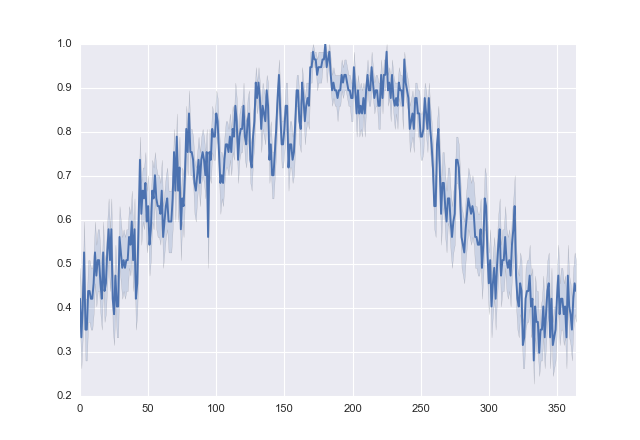

time: 399 ms


In [26]:
sns.tsplot(M_8['data'])